In [1]:
from salad.search import Search
from salad.directions import SearchDirections
from salad.hough import Hough
from salad.project import project
from salad.analysis.plot import plot_result, plot_cluster
from salad.cluster import Cluster
from salad.regression import regression
from salad.gather import gather
from salad.refine import refine
from salad.cluster.filter import filter_n, filter_velocity
from salad.serialize import read, write
from salad.fakes.recover import recover
from salad.cluster.join import join
from salad.measure.fitting import fit_trajectory, logL_position
from salad.line import Line
import pickle
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import logging
import lsst.geom

logging.basicConfig()
log = logging.getLogger(__name__)

class N:
    pass

args = N()
args.fakes = "../search/new_pipeline/DEEP/20190403/A0c/detector_1/fakes.pkl"
args.images = "../search/new_pipeline/DEEP/20190403/A0c/detector_1/images.pkl"
args.input = "../search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/catalog_no_crosstalk.pkl"
args.velocity = [0.1, 0.5]
args.angle = [120, 240]
args.dx = 10
args.vote_threshold = 25
args.min_points = 15
args.gather_threshold = [1, 1]


In [2]:
# fakes
fakes = read(args.fakes)
# images
images = read(args.images)

# catalog
catalog = read(args.input)
X = catalog.X(columns=['ra', 'dec', 'time', 'exposures'])
ra, dec, time, expnum = X[:, 0] * u.deg, X[:, 1] * u.deg, X[:, 2] * u.day, X[:, 3].astype(int)



In [3]:
# directions
dt = (max(catalog.time) - min(catalog.time))*u.day
reference_time = min(catalog.time) * u.day
v_range, phi_range, dx = (min(args.velocity)*u.deg/u.day, max(args.velocity)*u.deg/u.day), (min(args.angle)*u.deg, max(args.angle)*u.deg), args.dx*u.arcsec

b = SearchDirections(v_range, phi_range, dx, dt)



In [4]:
# projection
projection = project(X, b, reference_time)



In [10]:
# cluster
hough = Hough(projection, dx, dx)
hough.max()



109

In [11]:
# get clusters
clusters = []
for cluster in hough:
    votes = cluster.extra['votes']
    if votes < args.vote_threshold:
        break
    clusters.append(cluster)   

log.info("there are %d results after clustering", len(clusters))
recovered_clusters = recover(
    fakes, clusters, catalog, match_threshold_line=5/3600, projection=projection, hough=hough
)



In [17]:
len(clusters)

60

In [15]:
recovered_clusters

{13039521: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.14286354 deg / d>,
   'vdec': <Quantity 0.00333632 deg / d>,
   'min_dv': <Quantity 0.01059939 deg / d>,
   'distance': <Quantity 0.00189071 deg>,
   'findable': True}},
 10564514: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 21},
  'info': {'vra': <Quantity -0.11873689 deg / d>,
   'vdec': <Quantity 0.12091516 deg / d>,
   'min_dv': <Quantity 0.00778315 deg / d>,
   'distance': <Quantity 0.00027088 deg>,
   'findable': True}},
 14621325: {'points': {5: {'fake': 85, 'total': 93}},
  'line': {},
  'catalog': {'fake': 85, 'total': 104},
  'info': {'vra': <Quantity -0.14885475 deg / d>,
   'vdec': <Quantity 0.15269422 deg / d>,
   'min_dv': <Quantity 0.00714488 deg / d>,
   'distance': <Quantity 0.0012745 deg>,
   'findable': True}},
 10053463: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.15100897 deg / d>,


In [16]:
d = recovered_clusters
{k:d[k] for k in d if d[k]['info']['findable']}

{13039521: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.14286354 deg / d>,
   'vdec': <Quantity 0.00333632 deg / d>,
   'min_dv': <Quantity 0.01059939 deg / d>,
   'distance': <Quantity 0.00189071 deg>,
   'findable': True}},
 10564514: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 21},
  'info': {'vra': <Quantity -0.11873689 deg / d>,
   'vdec': <Quantity 0.12091516 deg / d>,
   'min_dv': <Quantity 0.00778315 deg / d>,
   'distance': <Quantity 0.00027088 deg>,
   'findable': True}},
 14621325: {'points': {5: {'fake': 85, 'total': 93}},
  'line': {},
  'catalog': {'fake': 85, 'total': 104},
  'info': {'vra': <Quantity -0.14885475 deg / d>,
   'vdec': <Quantity 0.15269422 deg / d>,
   'min_dv': <Quantity 0.00714488 deg / d>,
   'distance': <Quantity 0.0012745 deg>,
   'findable': True}},
 10053463: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.15100897 deg / d>,


In [18]:
# refine iteration 1
step1_removed = []
step1 = []
for i, cluster in enumerate(clusters):
    log.info("refining cluster %d / %d", i, len(clusters))
    result = refine(cluster)
    if result is None:
        step1_removed.append(cluster)
        continue

    mask = gather(result['line'], ra, dec, time, args.gather_threshold[0] * u.arcsec)
    gathered = Cluster(
        points=X[mask], 
        line=result['line'],
        extra=dict(result=result['result']),
    )
    step1.append(gathered)

log.info("there are %d results after refinement", len(step1))    
recovered_1 = recover(fakes, step1, catalog)
recovered_1_removed = recover(fakes, step1_removed, catalog)

In [19]:
# refine iteration 2
step2_removed = []
step2 = []
for cluster in step1:
    log.info("refining cluster %d / %d", i, len(step1))
    result = refine(cluster)
    if result is None:
        step2_removed.append(cluster)
        continue

    mask = gather(result['line'], ra, dec, time, args.gather_threshold[0] * u.arcsec)
    gathered = Cluster(
        points=X[mask], 
        line=result['line'],
        extra=dict(result=result['result']),
    )
    step2.append(gathered)

recovered_2 = recover(fakes, step2, catalog)
recovered_2_removed = recover(fakes, step2_removed, catalog)



/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [20]:
# filter velocity and number of detections
log.info("there are %d results after refinement", len(step2))
filtered = []
filtered_removed_velocity = []
filtered_removed_points = []
for cluster in step2:
    if filter_velocity(cluster, vmin=min(args.velocity), vmax=max(args.velocity)):
        if filter_n(cluster, n=args.min_points):
            filtered.append(cluster)
            continue
        else:
            filtered_removed_points.append(cluster)
    else:
        filtered_removed_velocity.append(cluster)

recovered_filter = recover(fakes, filtered, catalog)
recovered_filter_removed_velocity = recover(fakes, filtered_removed_velocity, catalog)
recovered_filter_removed_points = recover(fakes, filtered_removed_points, catalog)

log.info("there are %d results after filtering", len(filtered))



/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [21]:
# load exposures
exposures = {}
for image in images:
    exposures[image.expnum] = image.exposure
exp_times = np.array(list(map(lambda x : x.mjd_mid, images)))*u.day



In [28]:
bbox.clip(e.getBBox())
bbox

Box2I(corner=Point2I(924, 4087), dimensions=Extent2I(50, 9))

In [119]:
import astropy.time
visitInfo = exposures[845919].info.getVisitInfo()
(visitInfo.date.toAstropy() + astropy.time.TimeDelta(visitInfo.exposureTime / 2 + 0.5, format='sec')).value


58577.2970084601

In [22]:
# get cutouts

def attach_cutouts_from_images(clusters, images):
    exp_times = np.array(list(map(lambda x : x.mjd_mid, images))) * u.day
    wcss = list(map(lambda x : x.reader.readWcs(), images))
    bboxes = list(map(lambda x : x.reader.readBBox(), images))
#     photoCalibs = list(map(lambda x : x.reader.readPhotoCalib(), images))
#     psfs = list(map(lambda x : x.reader.readPsf(), images))
    for i, cluster in enumerate(clusters):
        log.info("getting cutouts for cluster %d/%d", i, len(clusters))
        locations = cluster.line.predict(exp_times)
        cutouts = {}
        centers = {}
        for (ra, dec), image, wcs, image_bbox in zip(locations, images, wcss, bboxes):
            p = wcs.skyToPixel(lsst.geom.SpherePoint(ra.value, dec.value, lsst.geom.degrees))
            expnum = image.visitInfo.id
            centers[expnum] = p
            bbox = lsst.geom.Box2I(lsst.geom.Point2I(p.getX() - 25, p.getY() - 25), lsst.geom.Extent2I(50, 50))
            bbox.clip(image_bbox)
            if bbox.getWidth() == 50 and bbox.getHeight() == 50:
                cutout = image.reader.read(bbox)
#                 cutout = lsst.afw.image.ExposureF(bbox, wcs)
#                 cutout.image = image.reader.readImage(bbox)
#                 cutout.variance = image.reader.readVariance(bbox)
#                 cutout.mask = image.reader.readMask(bbox)
#                 cutout.setPhotoCalib(photoCalib)
#                 cutout.setPsf(psf)
                cutouts[expnum] = cutout
#             else:
#                 cutouts.append(None)
        log.info("cluster %d has %d/%d cutouts", i, len(cutouts), len(images))
        cluster.cutouts = cutouts
        cluster.centers = centers
        
def times_for(exposures):
    import astropy.time
    times = []
    for e in exposures:
        times.append((exposures[e].visitInfo.date.toAstropy() + astropy.time.TimeDelta(exposures[e].visitInfo.exposureTime / 2 + 0.5, format='sec')).value)
    return np.array(times) * u.day
        
def attach_cutouts_from_exposures(clusters, exposures):
    exp_times = times_for(exposures)
    for i, cluster in enumerate(clusters):
        log.info("getting cutouts for cluster %d/%d", i, len(clusters))
        locations = cluster.line.predict(exp_times)
        cutouts = {}
        centers = {}
        for (ra, dec), expnum in zip(locations, exposures):
            exposure = exposures[expnum]
            p = exposure.wcs.skyToPixel(lsst.geom.SpherePoint(ra.value, dec.value, lsst.geom.degrees))
            centers[expnum] = p
            bbox = lsst.geom.Box2I(lsst.geom.Point2I(p.getX() - 25, p.getY() - 25), lsst.geom.Extent2I(50, 50))
            bbox.clip(exposure.getBBox())
            if bbox.getWidth() == 50 and bbox.getHeight() == 50:
                cutout = exposure.getCutout(bbox)
                cutouts[expnum] = cutout
#             else:
#                 cutouts[expnum].append(None)
        log.info("cluster %d has %d/%d cutouts", i, len(cutouts), len(images))
        cluster.cutouts = cutouts
        cluster.centers = centers
        

# attach_cutouts(filtered, images)

In [23]:
%%time
attach_cutouts_from_images(filtered, images)

CPU times: user 17.8 s, sys: 805 ms, total: 18.6 s
Wall time: 18.7 s


In [24]:
%%time
attach_cutouts_from_exposures(filtered, exposures)

CPU times: user 374 ms, sys: 42 ms, total: 416 ms
Wall time: 414 ms


In [25]:
len(filtered)

16

In [27]:
# fit trajectory
fitted = []
fit_removed = []
for i, cluster in enumerate(filtered):
    cs = []
    ps = []
    ts = []
    for e, t in zip(cluster.cutouts, exp_times):
        cs.append(cluster.cutouts[e])
        ps.append(cluster.centers[e])
        ts.append(t.value)
            
    trajectory_fit = fit_trajectory(
        cs, 
        ps, 
        np.array(ts), 
        lambda p, t : (p[0] * t + p[2], p[1] * t + p[3]), 
        start=np.hstack([cluster.line.beta.value.flatten(), cluster.line.alpha.value.flatten()])
    )
    if trajectory_fit.success:
        fitted.append(
            Cluster(
                points=cluster.points, 
                line=Line(
                    beta=trajectory_fit.x[:2]*cluster.line.beta.unit,
                    alpha=trajectory_fit.x[2:]*cluster.line.alpha.unit,
                ),
                extra=dict(
                    fit=trajectory_fit,
                )
            )
        )
    else:
        fit_removed.append(cluster)

log.info("there are %d results after fittting", len(fitted))

/epyc/projects/salad/src/salad/measure/fitting.py:25: RuntimeWarning: invalid value encountered in scalar divide
  f = c/a # flux estimate; Whidden et al. 2019 Eq. 22 (alpha_ML)
/epyc/projects/salad/src/salad/measure/fitting.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = 1/np.sqrt(a) # standard deviation in flux estimate
/epyc/projects/salad/src/salad/measure/fitting.py:27: RuntimeWarning: invalid value encountered in scalar divide
  snr = c / np.sqrt(a) # signal to noise -- why is this not f / sigma?; Whidden et al. 2019 Eq. 26 (nu_coadd)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


In [28]:
recovered_fitted = recover(fakes, fitted, catalog)
recovered_fitted_removed = recover(fakes, fit_removed, catalog)

In [30]:
attach_cutouts_from_exposures(fitted, exposures)

In [31]:
def zeropoint_correction(orig, zp):
    return 10**(-2/5 * (orig - zp))

def summary(cluster):
    # create a summary of the cluster from the cutouts
    # creates coadds and light curves
    ref_zp = 31
    
    c = list(filter(lambda x : x is not None, cluster.cutouts))
    
    image = []
    variance = []
    mask = []
    flux = []
    sigma = []
    snr = []
    mag = []
    lc_mask = []
    for expnum in cluster.cutouts:
        cutout = cluster.cutouts[expnum]
        center = cluster.centers[expnum]
        
        k = zeropoint_correction(cutout.info.getSummaryStats().zeroPoint, ref_zp)
        image.append(cutout.image.array * k)
        variance.append(cutout.variance.array * k**2)
        mask.append(cutout.mask.array)
        
        phot_result = logL_position(cutout, center, [0, 0], ref_zp=ref_zp)
        flux.append(phot_result['flux_ref'])
        sigma.append(phot_result['sigma_ref'])
        snr.append(phot_result['SNR'])
        mag.append(phot_result['mag'])
        lc_mask.append(phot_result['mask'])

    image = np.array(image)
    variance = np.array(variance)
    mask = np.array(mask)
    flux = np.array(flux)
    sigma = np.array(sigma)
    snr = np.array(snr)
    mag = np.array(mag)
    lc_mask = np.array(lc_mask)
        
    mean_coadd = np.mean(image, axis=0)
    sum_coadd = np.sum(image, axis=0)
    median_coadd = np.sum(image, axis=0)
    weighted_coadd = (np.sum((image / variance), axis=0) / np.sum(1/variance, axis=0))
    
    return {
        "image": image,
        "variance": variance,
        "mask": mask,
        "coadd": {
            "sum": sum_coadd,
            "mean": mean_coadd,
            "median": median_coadd,
            "weighted": weighted_coadd,
        },
        "light_curve": {
            "flux": flux,
            "sigma": sigma,
            "snr": snr,
            "mag": mag,
            "mask": lc_mask,
        }
    }

In [32]:
len(filtered), len(filtered_removed_velocity), len(filtered_removed_points)

(16, 37, 7)

In [33]:
len(fitted), len(fit_removed)

(13, 3)

In [73]:
import matplotlib.pyplot as plt

In [51]:
c = read("../search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/single_search/clusters.pkl")
attach_cutouts_from_exposures(
    c,
    exposures
)


In [ ]:
write(c, "/tmp/c.pkl")

In [37]:
attach_cutouts_from_exposures(filtered, exposures)
attach_cutouts_from_exposures(filtered_removed_points, exposures)
attach_cutouts_from_exposures(filtered_removed_velocity, exposures)

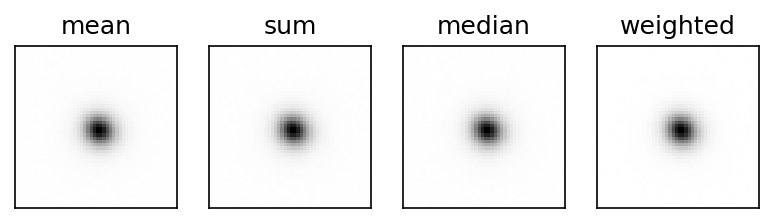

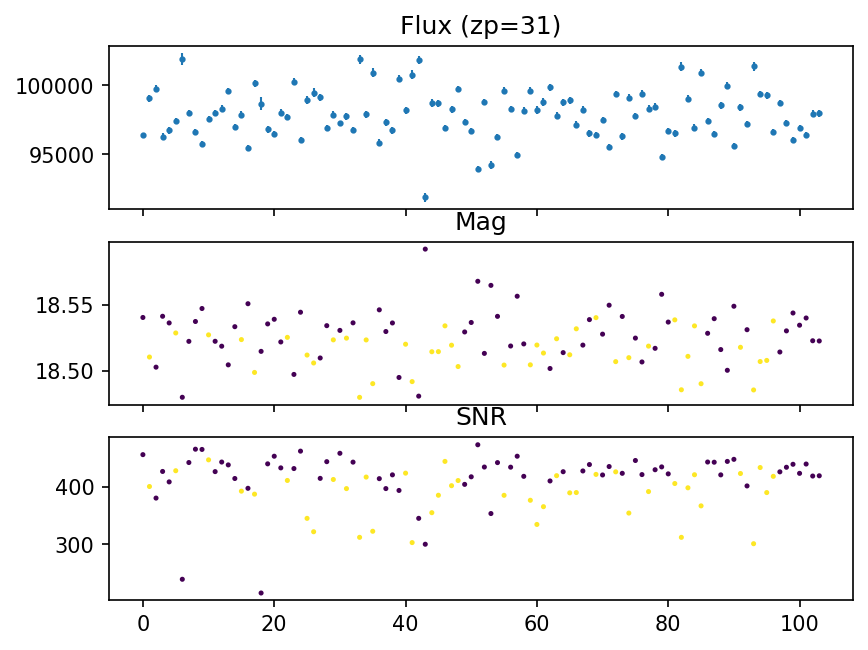

In [43]:
cluster = filtered[0]
s = summary(cluster)

fig = plt.figure(dpi=150)
axs = fig.subplots(1, 4)
plt.sca(axs[0])
plt.imshow(s['coadd']['mean'], cmap='gray_r')
plt.title("mean")
plt.xticks([])
plt.yticks([])

plt.sca(axs[1])
plt.imshow(s['coadd']['sum'], cmap='gray_r')
plt.title("sum")
plt.xticks([])
plt.yticks([])

plt.sca(axs[2])
plt.imshow(s['coadd']['median'], cmap='gray_r')
plt.title("median")
plt.xticks([])
plt.yticks([])

plt.sca(axs[3])
plt.imshow(s['coadd']['weighted'], cmap='gray_r')
plt.title("weighted")
plt.xticks([])
plt.yticks([])

plt.show()

fig = plt.figure(dpi=150)
axs = fig.subplots(3, 1, sharex=True)
plt.sca(axs[0])
plt.errorbar(
    np.arange(len(s['light_curve']['flux'])), 
    s['light_curve']['flux'], 
    yerr=s['light_curve']['sigma'],
    fmt='o',
#     c=s['light_curve']['mask'],
    ms=2,
    lw=1,
)
plt.title("Flux (zp=31)")
plt.sca(axs[1])
plt.scatter(
    np.arange(len(s['light_curve']['flux'])), 
    s['light_curve']['mag'],
    c=s['light_curve']['mask'] != 0,
    s=2
)
plt.title("Mag")
plt.sca(axs[2])
plt.scatter(
    np.arange(len(s['light_curve']['flux'])), 
    s['light_curve']['snr'],
    c=s['light_curve']['mask'] != 0,
    s=2
)
plt.title("SNR")
plt.show()

# plt.scatter(cluster.points[:, 0], cluster.points[:, 1])
# plt.show()

In [288]:
def plot_cluster_cutouts(
    cluster, 
    cols=None, rows=None, 
    component="", 
    title="{visit}",#"\n({x}, {y})\nSNR={significance:0.1f}", 
    show_colorbar=False, 
    highlight_points=True,
    limit=None,
    only_points=False,
    stretch="linear",
    scale="zscale",
    **kwargs
):
    import matplotlib.pyplot as plt
    import lsst.afw.display as afwDisplay
    import numpy as np
    
    expnum = sorted(list(cluster.cutouts.keys()))
    
    if only_points:
        expnum = sorted(list(set(cluster.points[:, 3])))
    
    if limit:
        expnum = expnum[:limit]
    
    if len(expnum) == 0:
        return None, None
    
    afwDisplay.setDefaultBackend("matplotlib")
    if rows is not None and cols is None:
        cols = len(expnum) / rows
    elif rows is None and cols is not None:
        rows = len(expnum) / cols
    elif rows is None and cols is None:
        cols = round((len(expnum))**0.5 + 0.5)
        rows = len(expnum)/cols
                
    if cols > len(expnum):
        cols = len(expnum)
        rows = 1

    if (cols - int(cols)) != 0:
        cols += 1
    cols = int(cols)
        
    if (rows - int(rows)) != 0:
        rows += 1
    rows = int(rows)

    print(rows, cols)
    fig = plt.figure(figsize=(cols*2, rows*2), **kwargs)
    axs = fig.subplots(rows, cols)
    axs = np.atleast_2d(axs)
    display = afwDisplay.Display(frame=fig)
    display.scale(stretch, scale)
    
    for ax, e in zip(axs.flatten(), expnum):
        plt.sca(ax)
        cutout = cluster.cutouts[e]
        center = cluster.centers[e]
        a = cutout
        if component:
            a = getattr(cutout, component)
        display.mtv(a)

        visit = cutout.getInfo().getVisitInfo().getId()
#         x = center.getX()
#         y = center.getY()
#         snr = 
#         x = int(row['i_x'])
#         y = int(row['i_y'])
#         significance = get_significance(row)
        plt.title(title.format(**locals()))

        if highlight_points:
            if np.isin(visit, cluster.points[:, 3]):
                mask = cluster.points[:, 3] == visit
                ax.spines['bottom'].set_color('red')
                ax.spines['top'].set_color('red')
                ax.spines['left'].set_color('red')
                ax.spines['right'].set_color('red')
                for ra, dec, _, _ in cluster.points[mask]:
                    p = cutout.wcs.skyToPixel(lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees))
                    display.dot("+", p.getX(), p.getY())

        display.show_colorbar(show=show_colorbar)
        
    if len(axs.flatten()) > len(expnum):
        for ax in axs.flatten()[len(expnum):]:
            ax.remove()
    return fig, axs


In [387]:
list(map(lambda x : len(x.points), filtered_removed_velocity))

[25,
 10,
 8,
 11,
 9,
 21,
 6,
 13,
 14,
 23,
 5,
 38,
 21,
 27,
 13,
 25,
 41,
 16,
 3,
 29,
 16,
 40,
 8,
 10,
 9,
 29,
 9,
 6,
 5,
 11,
 12,
 13,
 48,
 48,
 26]

In [386]:
list(map(lambda x : len(x.points), filtered_removed_points))

[4, 4, 6, 6, 7, 2, 3, 2]

3 3


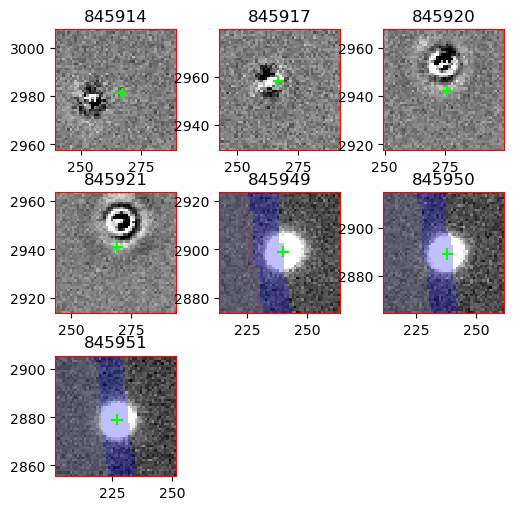

In [374]:
fig, axs = plot_cluster_cutouts(filtered_removed_points[4], only_points=True)

In [46]:
recovered_filter

{13039521: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.14286354 deg / d>,
   'vdec': <Quantity 0.00333632 deg / d>}},
 10564514: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 21},
  'info': {'vra': <Quantity -0.11873689 deg / d>,
   'vdec': <Quantity 0.12091516 deg / d>}},
 14621325: {'points': {5: {'fake': 85, 'total': 85}},
  'line': {5: {'fake': 104, 'total': 104}},
  'catalog': {'fake': 85, 'total': 104},
  'info': {'vra': <Quantity -0.14885475 deg / d>,
   'vdec': <Quantity 0.15269422 deg / d>}},
 10053463: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.15100897 deg / d>,
   'vdec': <Quantity 0.00298646 deg / d>}},
 13776855: {'points': {10: {'fake': 47, 'total': 47}},
  'line': {10: {'fake': 104, 'total': 104}},
  'catalog': {'fake': 47, 'total': 104},
  'info': {'vra': <Quantity -0.12566953 deg / d>,
   'vdec': <Quantity 0.18511984 deg / d>}},
 14813564: 

In [48]:
def was_found(fake_recovery):
    ret = {}
    for o in fake_recovery:
        f = fake_recovery[o]
        found = False
        for c in f['points']:
            p = f['points'][c]
            precision = p['fake']/p['total']
            recall = p['fake']/f['catalog']['fake']
            if c in f['line']:
                l = f['line'][c]
                line_recovery = l['fake']/l['total']
                if precision > 0.5 and line_recovery > 0.5:
                    found = True
        ret[o] = found
    return ret
            
was_found(recovered_filter)

{13039521: False,
 10564514: False,
 14621325: True,
 10053463: False,
 13776855: True,
 14813564: False,
 10041343: False}

In [ ]:
# now I need to run this across multiple detectors

In [440]:
list(map(lambda x: (((np.diag(x.extra['result'].sigma_e)**0.5)*3600)**2).sum()**0.5, filtered))

[0.11427096089780014,
 0.12428950635799434,
 0.15644821660106836,
 0.11525014905459971,
 0.1324963061220734,
 0.11741081782841395,
 0.1774565683709992,
 0.16944413009159628,
 0.12664229773342112,
 0.2478690384312137,
 0.2688819683396707,
 0.22680943939813078,
 0.11767455856451445,
 0.11828112029990036,
 0.11427096089780014,
 0.11855626461544894]

In [441]:
list(map(lambda x: (((np.diag(x.extra['result'].sigma_e)**0.5)*3600)**2).sum()**0.5, filtered_removed_velocity))

[0.47494123913808284,
 0.32982649470432385,
 0.6051552834764958,
 0.48417126262450666,
 0.6407063149229273,
 0.5368661393618938,
 0.45423932362321284,
 0.1766398678343748,
 0.3683263092052005,
 0.5124113442641004,
 0.3349062566483305,
 0.4982185584912398,
 0.483706678808039,
 0.5537947116596027,
 0.35137380108927263,
 0.40652694266368955,
 0.4692519137342942,
 0.34658385986752593,
 0.5304780265914032,
 0.42765209332632476,
 0.17888175678313623,
 0.5288252800204879,
 0.607084888153174,
 0.24922731401832632,
 0.3457536178553146,
 0.5035923116918555,
 0.49254220266475823,
 0.45258921107297095,
 0.6150495353884445,
 0.5442940895786831,
 0.39568143011775925,
 0.5026046887357015,
 0.2160303982813529,
 0.21210234426362876,
 0.21338448610340974]

In [442]:
list(map(lambda x: (((np.diag(x.extra['result'].sigma_e)**0.5)*3600)**2).sum()**0.5, filtered_removed_points))

/tmp/ipykernel_81591/3977742950.py:1: RuntimeWarning: invalid value encountered in sqrt
  list(map(lambda x: (((np.diag(x.extra['result'].sigma_e)**0.5)*3600)**2).sum()**0.5, filtered_removed_points))


[nan,
 0.6297403125095644,
 0.6519169451299465,
 0.4566000029119056,
 0.5783446475950161,
 nan,
 0.2557672791464341,
 1.4817251429611184e-07]

In [423]:
filtered_removed_points[2].extra['result'].sigma_e

array([[ 5.34365691e-09, -1.20639075e-08],
       [-1.20639075e-08,  2.74492214e-08]])

In [439]:
(((np.diag(filtered_removed_velocity[5].extra['result'].sigma_e)**0.5)*3600)**2).sum()**0.5

0.5368661393618938

In [375]:
filtered_removed_points[4].cutouts[845951].mask.getMaskPlaneDict()

{'BAD': 0,
 'CLIPPED': 9,
 'CR': 3,
 'CROSSTALK': 10,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'FAKE': 11,
 'INEXACT_PSF': 12,
 'INJECTED': 13,
 'INJECTED_TEMPLATE': 14,
 'INTRP': 2,
 'NOT_DEBLENDED': 15,
 'NO_DATA': 8,
 'REJECTED': 16,
 'SAT': 1,
 'SENSOR_EDGE': 17,
 'STREAK': 18,
 'SUSPECT': 7,
 'UNMASKEDNAN': 19}

In [380]:
(filtered_removed_points[4].cutouts[845951].mask[202+25, 2856+25])

2048

In [382]:
(filtered_removed_points[4].cutouts[845951].mask[202+25, 2856+25] >> 11) & 1

1

In [336]:
display.getMaskPlaneColor()

{'BAD': 'red',
 'CR': 'magenta',
 'EDGE': 'yellow',
 'INTERPOLATED': 'green',
 'SATURATED': 'green',
 'DETECTED': 'blue',
 'DETECTED_NEGATIVE': 'cyan',
 'SUSPECT': 'yellow',
 'NO_DATA': 'orange',
 'INTRP': 'green',
 'SAT': 'green',
 'CLIPPED': 'red',
 'CROSSTALK': 'green',
 'FAKE': 'blue',
 'INEXACT_PSF': 'cyan',
 'INJECTED': 'magenta',
 'INJECTED_TEMPLATE': 'yellow',
 'NOT_DEBLENDED': 'orange',
 'REJECTED': 'red',
 'SENSOR_EDGE': 'green',
 'STREAK': 'blue',
 'UNMASKEDNAN': 'cyan'}

In [310]:
filtered_removed[5].cutouts[845956].mask.getMaskPlaneDict()

{'BAD': 0,
 'CLIPPED': 9,
 'CR': 3,
 'CROSSTALK': 10,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'FAKE': 11,
 'INEXACT_PSF': 12,
 'INJECTED': 13,
 'INJECTED_TEMPLATE': 14,
 'INTRP': 2,
 'NOT_DEBLENDED': 15,
 'NO_DATA': 8,
 'REJECTED': 16,
 'SAT': 1,
 'SENSOR_EDGE': 17,
 'STREAK': 18,
 'SUSPECT': 7,
 'UNMASKEDNAN': 19}

In [301]:
2**9

512

In [314]:
(filtered_removed[5].cutouts[845956].mask[193 + 25, 3517 + 25] >> 15) & 1

1

216.1169374023229 -11.031184255413994 58577.35231478186 845951.0
(565, 1784)
(minimum=(540, 1758), maximum=(589, 1807))


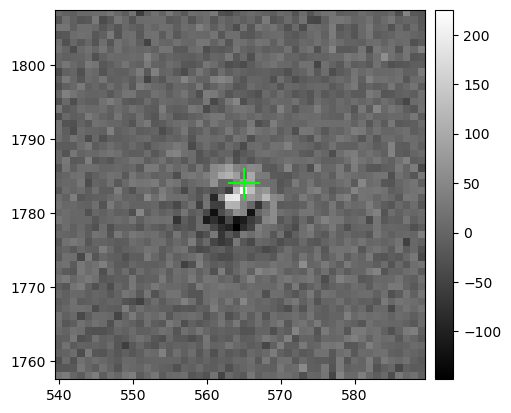

216.1307583328693 -11.034639685143155 58577.27277321322 845905.0
(597, 1967)
(minimum=(574, 1941), maximum=(623, 1990))


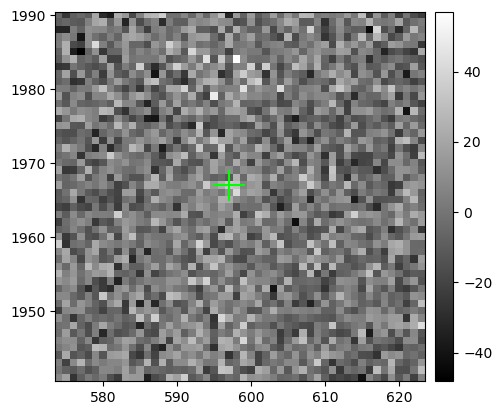

In [252]:
attach_cutouts_from_exposures(step2_removed, exposures)
cluster = step2_removed[0]

for ra, dec, time, expnum in cluster.points:
    ra_pred, dec_pred = cluster.line.predict(time*u.day)[0]
    expnum = int(expnum)
    cutout = cluster.cutouts[expnum]

    fig = plt.figure()
    display = afwDisplay.Display(frame=fig)
    display.mtv(cutout.image)
    p = cutout.wcs.skyToPixel(lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees))
    display.dot("+", p.getX(), p.getY())
#     p = cutout.wcs.skyToPixel(lsst.geom.SpherePoint(ra_pred.value, dec_pred.value, lsst.geom.degrees))
#     print(p)
#     display.dot("+", p.getX(), p.getY())
    plt.show()

#     bbox = cutout.getBBox()
#     x = p.getX() - bbox.beginX
#     y = p.getY() - bbox.beginY
#     plt.imshow(cutout.image.array, cmap='gray_r')
#     plt.scatter(x, y)
#     plt.show()

216.12946199253983 -11.031662211040674 58577.33991330024 845944.0
(576, 1995)
(minimum=(550, 1969), maximum=(599, 2018))


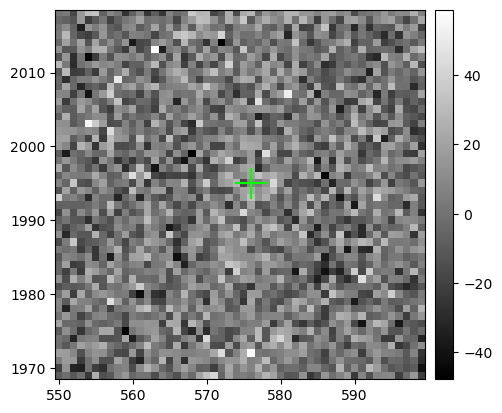

216.1283976796301 -11.030829020939699 58577.350590350106 845950.0
(568, 1945)
(minimum=(542, 1919), maximum=(591, 1968))


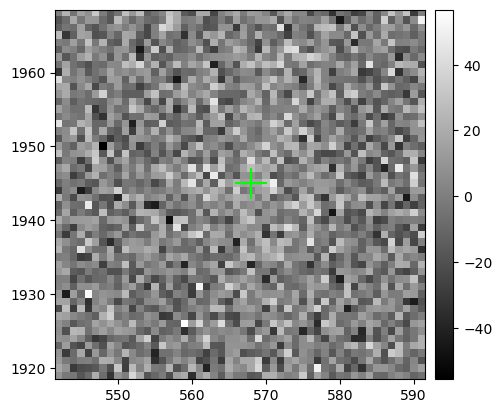

216.13433678059005 -11.035269663039312 58577.29167612828 845916.0
(599, 2031)
(minimum=(576, 2007), maximum=(625, 2056))


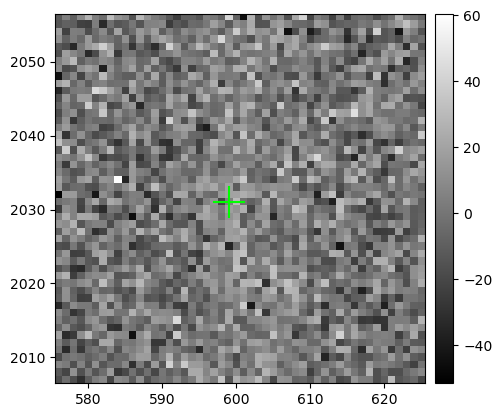

216.12846520537545 -11.030950944959299 58577.34887263365 845949.0
(570, 1952)
(minimum=(545, 1927), maximum=(594, 1976))


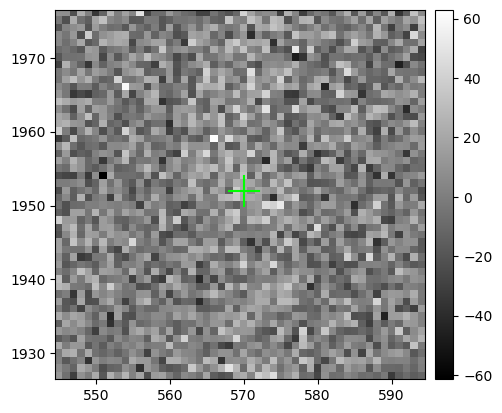

216.13181291030233 -11.033261577602815 58577.31930518523 845932.0
(586, 1988)
(minimum=(561, 1959), maximum=(610, 2008))


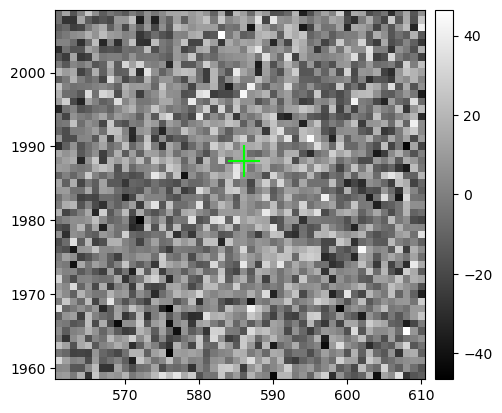

216.13765227481727 -11.037963361817212 58577.25853315601 845897.0
(620, 2065)
(minimum=(596, 2042), maximum=(645, 2091))


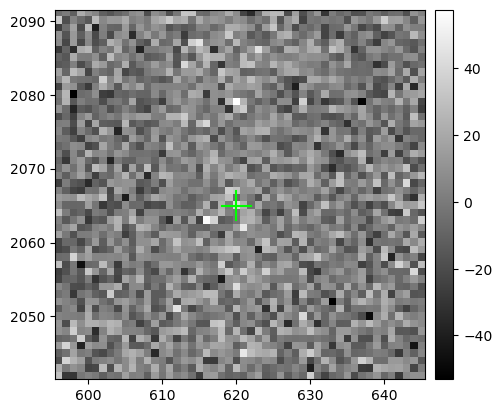

216.1298775541677 -11.032057118109515 58577.33475460578 845941.0
(578, 1983)
(minimum=(553, 1959), maximum=(602, 2008))


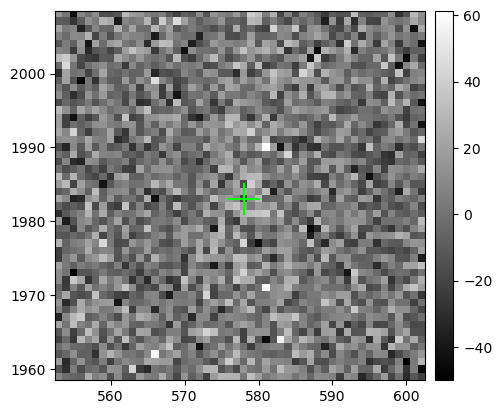

In [254]:
attach_cutouts_from_exposures(filtered_removed, exposures)
cluster = filtered_removed[0]

for ra, dec, time, expnum in cluster.points:
    print(ra, dec, time, expnum)
    ra_pred, dec_pred = cluster.line.predict(time*u.day)[0]
    expnum = int(expnum)
    cutout = cluster.cutouts[expnum]

    fig = plt.figure()
    display = afwDisplay.Display(frame=fig)
    display.mtv(cutout.image)
    p = cutout.wcs.skyToPixel(lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees))
    print(p)
    display.dot("+", p.getX(), p.getY())
#     p = cutout.wcs.skyToPixel(lsst.geom.SpherePoint(ra_pred.value, dec_pred.value, lsst.geom.degrees))
#     print(p)
#     display.dot("+", p.getX(), p.getY())
    print(cutout.getBBox())
    plt.show()

#     bbox = cutout.getBBox()
#     x = p.getX() - bbox.beginX
#     y = p.getY() - bbox.beginY
#     plt.imshow(cutout.image.array, cmap='gray_r')
#     plt.scatter(x, y)
#     plt.show()

In [200]:
bbox = cutout.getBBox()
bbox.beginX

131

In [216]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend("matplotlib")

<Figure size 640x480 with 0 Axes>

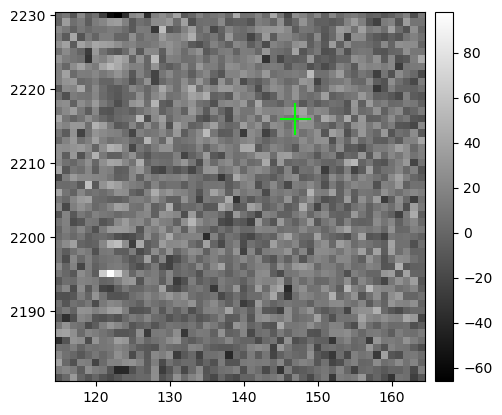

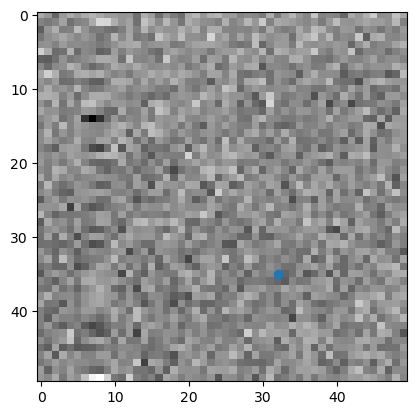

<Figure size 640x480 with 0 Axes>

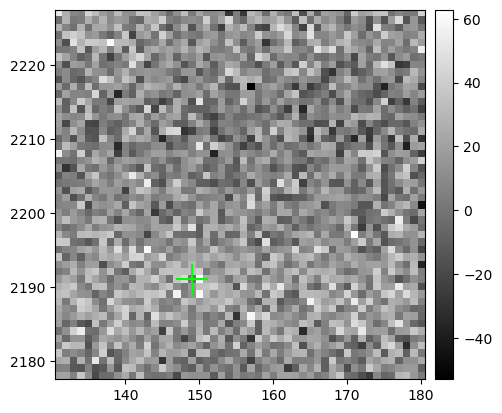

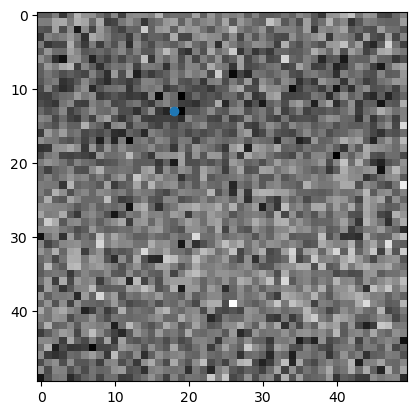

In [215]:
cluster.cutouts

{845919: <lsst.afw.image._exposure.ExposureF at 0x7f5ff2812fb0>,
 845952: <lsst.afw.image._exposure.ExposureF at 0x7f5ff311d970>,
 845899: <lsst.afw.image._exposure.ExposureF at 0x7f5ff33f2c70>,
 845890: <lsst.afw.image._exposure.ExposureF at 0x7f5ff3618e70>,
 845881: <lsst.afw.image._exposure.ExposureF at 0x7f5ff3618930>,
 845948: <lsst.afw.image._exposure.ExposureF at 0x7f5ff3618d30>,
 845927: <lsst.afw.image._exposure.ExposureF at 0x7f5ff34c8e70>,
 845892: <lsst.afw.image._exposure.ExposureF at 0x7f5ff34cbcb0>,
 845918: <lsst.afw.image._exposure.ExposureF at 0x7f5ff34cbdb0>,
 845920: <lsst.afw.image._exposure.ExposureF at 0x7f5ff347c4b0>,
 845945: <lsst.afw.image._exposure.ExposureF at 0x7f5ff347c1f0>,
 845901: <lsst.afw.image._exposure.ExposureF at 0x7f5ff33141b0>,
 845915: <lsst.afw.image._exposure.ExposureF at 0x7f5ff3314030>,
 845935: <lsst.afw.image._exposure.ExposureF at 0x7f5ff33160b0>,
 845939: <lsst.afw.image._exposure.ExposureF at 0x7f5ff3317db0>,
 845964: <lsst.afw.image.

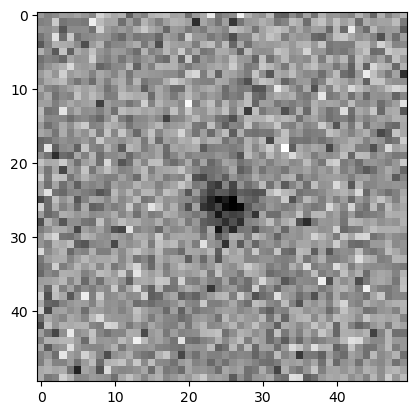

In [110]:
plt.imshow(s['image'][0], cmap='gray_r')

In [1]:
# from salad.images import Image
detector = 1
images = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/images.pkl")


In [7]:
exptimes = np.array(list(map(lambda x : x.mjd_mid, images)))

In [8]:
detector = 1
snr = 5.0
catalog = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/catalog.pkl")
projection = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/projection.pkl")
images = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/images.pkl")

X = catalog.X(columns=['ra', 'dec', 'time', 'exposures'], sky_units=u.deg, time_units=u.day)
ra, dec, time = X[:, 0] * u.deg, X[:, 1] * u.deg, X[:, 2] * u.day

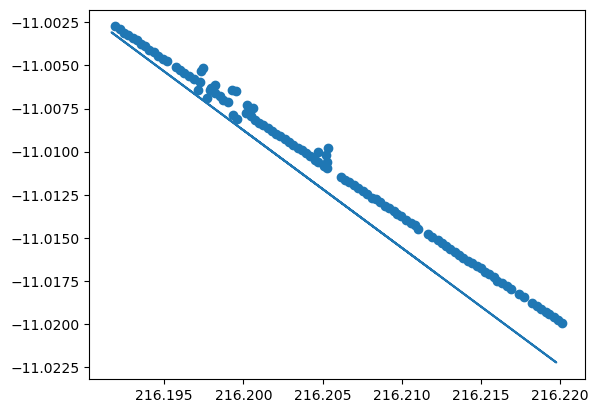

In [33]:
import matplotlib.pyplot as plt

hough = Hough(projection, 10*u.arcsec, 10*u.arcsec)
cluster = next(iter(hough))
x = catalog.time
y = cluster.line.predict(catalog.time)
plt.plot(y[:, 0], y[:, 1])
plt.scatter(cluster.points[:, 0], cluster.points[:, 1])
plt.show()

In [28]:
catalog.time.shape

(12767,)

In [29]:
exptimes.shape

(104,)

In [17]:
cluster.line.offset

58577.21560552204

In [19]:
cluster.line.predict(catalog.time)

<Quantity [[216.19991951, -11.00870237],
           [216.19991951, -11.00870237],
           [216.19991951, -11.00870237],
           ...,
           [216.21218943, -11.01706784],
           [216.21218943, -11.01706784],
           [216.21218943, -11.01706784]] deg>

In [34]:
cluster.line.predict(exptimes * u.day)

<Quantity [[216.20694231, -11.01349043],
           [216.19796632, -11.00737071],
           [216.21245927, -11.01725182],
           [216.21488891, -11.01890832],
           [216.21731735, -11.02056399],
           [216.19905136, -11.00811048],
           [216.20478141, -11.01201715],
           [216.21434814, -11.01853962],
           [216.20721185, -11.0136742 ],
           [216.20667121, -11.01330559],
           [216.19991951, -11.00870237],
           [216.21191868, -11.01688325],
           [216.20805261, -11.01424741],
           [216.2026203 , -11.01054374],
           [216.20154014, -11.00980729],
           [216.19465024, -11.00510985],
           [216.20370218, -11.01128135],
           [216.19688349, -11.00663246],
           [216.20451151, -11.01183314],
           [216.21407886, -11.01835603],
           [216.21021622, -11.01572253],
           [216.20940619, -11.01517027],
           [216.1987784 , -11.00792438],
           [216.20832341, -11.01443204],
           [216.

In [38]:
cluster.line

In [116]:
def _refine(cluster):
    result = refine(cluster)
    line = Line(
        alpha=result.alpha * cluster.line.alpha.unit,
        beta=result.beta * cluster.line.beta.unit
    )
    return line, result

def gather(line, ra, dec, time, threshold):
    pred = line.predict(time)
    target = np.array([ra, dec]).T
    if hasattr(ra, "unit"):
        target *= ra.unit
    residuals = (target - pred)
    distance = (residuals**2).sum(axis=1)**0.5
    mask = distance < threshold
    return mask
    

In [105]:
line.predict(catalog.time)

<Quantity [[216.20016904, -11.00780533],
           [216.20016904, -11.00780533],
           [216.20016904, -11.00780533],
           ...,
           [216.21253209, -11.01531424],
           [216.21253209, -11.01531424],
           [216.21253209, -11.01531424]] deg>

In [118]:
line, result = _refine(cluster)
refined = Cluster(
    points=gather(line, ra, dec, time, 1 * u.arcsec),
    line=line,
    extra=dict(regression=result),
)

In [122]:
refined.line.predict(catalog.time)

<Quantity [[216.20016904, -11.00780533],
           [216.20016904, -11.00780533],
           [216.20016904, -11.00780533],
           ...,
           [216.21253209, -11.01531424],
           [216.21253209, -11.01531424],
           [216.21253209, -11.01531424]] deg>

In [46]:
np.atleast_2d(catalog.time).shape

(1, 12767)

(1, 2) (1, 12767) (1, 2)


(2, 12767)

In [43]:
np.atleast_2d([1, 1]).shape

(1, 2)